In [1]:
import tensorflow as tf
from generative_models.vae import VAE
from common.data_loader import load_test_raw_data


/usr/local/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
from utils.utils import get_latent_vector_column
from config.common_path import get_encoded_csv_file

from config import ExperimentConfig
from experiments.experiment import Experiment
from analysis.decoder import decode

%matplotlib inline

In [3]:
colormap = "Greys"

In [4]:
run_id = 1
ROOT_PATH = "/Users/sunilkumar/concept_learning/image_classification_5epoch/"
config1 = ExperimentConfig(ROOT_PATH, 4, 10, [64, 128, 32])
config2 = ExperimentConfig(ROOT_PATH, 4, 5, [64, 128, 32])
exp_config = config1
exp = Experiment(1, "VAE_MNIST", 128, exp_config, run_id)
exp_config.create_directories(run_id)
N_3 = exp_config.num_units[exp_config.num_decoder_layer - 2]
N_2 = exp_config.num_units[exp_config.num_decoder_layer - 3]
Z_DIM = exp_config.Z_DIM
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name
DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS = exp_config.DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS
PREDICTION_RESULTS_PATH = exp_config.PREDICTION_RESULTS_PATH
LOG_PATH = exp_config.LOG_PATH
TRAINED_MODELS_PATH = exp_config.TRAINED_MODELS_PATH
ANALYSIS_PATH = exp_config.ANALYSIS_PATH

In [5]:
filename = get_encoded_csv_file(N_2, N_3, Z_DIM, "val")
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
df.shape

(128, 31)

In [6]:
mean_col_names, sigma_col_names, z_col_names = get_latent_vector_column(Z_DIM)

In [7]:
def get_labels(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS):
    x,y = load_test_raw_data(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS)
    labels = np.unique(y)
    return labels
    

In [8]:
labels = get_labels(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS)


In [9]:
def get_mean(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.mean(axis=0)
    return mu_0


def get_min(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.min(axis=0)
    return mu_0


def get_max(i,df,mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.max(axis=0)
    return mu_0

In [10]:
mu_mean = []
mu_min = []
mu_max =[]
for i in labels:
    mu_mean.append( get_mean(i, df,z_col_names) )
    mu_min.append( get_min(i, df,z_col_names) )
    mu_max.append( get_max(i, df,z_col_names) )



In [11]:
print(mu_min[0])
print(mu_max[0])
print(mu_mean[0])

[-1.2682189  -2.1077423  -1.1623639  -0.5684998  -1.5586478  -0.7093931
 -1.3932136  -0.94720376 -2.634881   -1.4541214 ]
[ 1.1803317   1.315334    1.4975607   1.8056988   0.9744046   1.8561614
  1.0187083   1.3001374  -0.47088468  1.1034918 ]
[-0.00372914  0.09517444 -0.00315056  0.76076254 -0.21150259  0.53329271
 -0.14794758 -0.11960177 -1.60469779 -0.16310475]


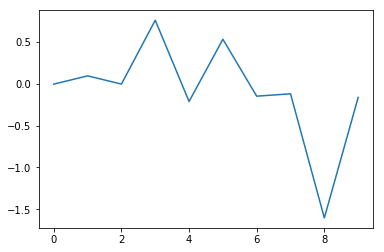

In [12]:
plt.plot(mu_mean[0])

In [13]:
def trace(trace_from, trace_to, mu_mean, num_trace_steps, d):    
    z = np.zeros([num_trace_steps , Z_DIM])
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, d ] = alpha_i * mu_mean[trace_to][d] + (1 - alpha_i) * mu_mean[trace_from][d]
    return z
    
    

In [14]:
def trace_dim(mu, num_trace_steps,  dim):    
    z = np.zeros([num_trace_steps , Z_DIM])
    for i in range(num_trace_steps):
        z[i] = mu
    z_min =  -5
    z_max = 5
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, dim ] = alpha_i * z_min + (1 - alpha_i) * z_max
    return z
    
    

In [15]:
# d = list(range(len(labels)))
# num_trace_steps = 36
# with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
#     model = VAE(sess,
#             epoch=1,
#             batch_size=BATCH_SIZE,
#             z_dim=Z_DIM,
#             dataset_name=DATASET_NAME)
#     model.set_result_directories(log_dir=LOG_PATH,
#             checkpoint_dir=TRAINED_MODELS_PATH,
#             result_dir=PREDICTION_RESULTS_PATH)

#     # build graph
#     model.build_model()

#     # show network architecture
#     checkpoint_counter = model.load_from_checkpoint()
#     print("Check point counter", checkpoint_counter)
#     total_latent_vectors = len(labels) + (len(labels) - 1) * num_trace_steps
#     if total_latent_vectors < BATCH_SIZE:
#         total_latent_vectors = BATCH_SIZE
#     z = np.zeros([total_latent_vectors, Z_DIM])
#     for i in range(len(mu_mean)):
#         z[i, :] = mu_mean[i]
#     num_latent_vectors = len(mu_mean)
        
#     for label_index in range(len(labels) - 1):
#         traced_from_to = trace(label_index, label_index + 1, mu_mean, num_trace_steps, d)
#         for i in range(num_trace_steps):
#             z[ num_latent_vectors, :] = traced_from_to[i]
#             num_latent_vectors += 1
#     reconstructed_images = decode(model, z, BATCH_SIZE)

NameError: name 'reconstructed_images' is not defined

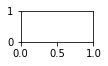

In [17]:
figure = plt.subplot(3, 3, 1)
for i in range(len(labels) ):
    plt.subplot(6, 4, i+1)
    plt.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)
    


# Trace from one label to next

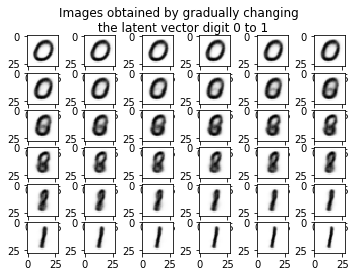

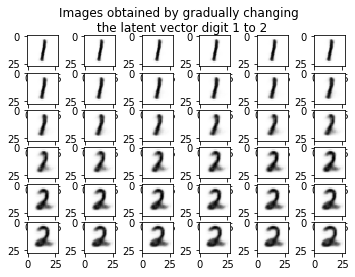

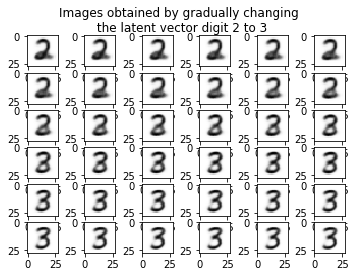

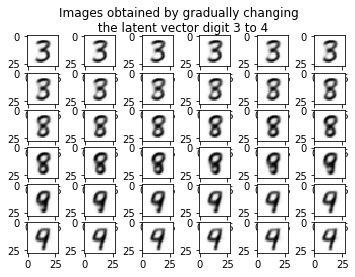

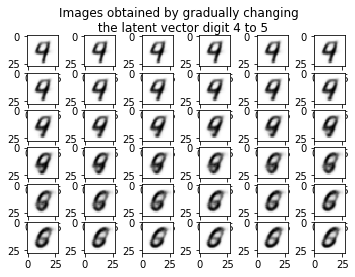

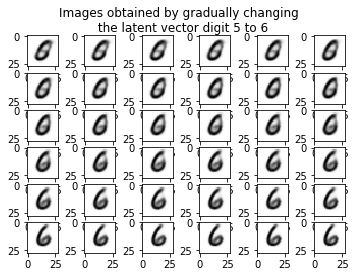

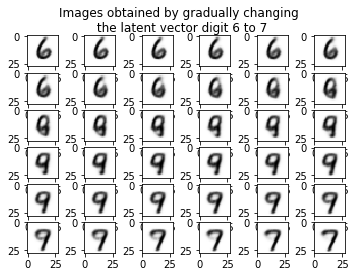

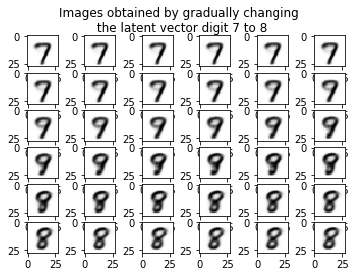

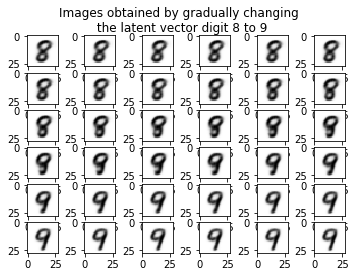

In [16]:
num_images_plotted = len(labels)
title_string = "Images obtained by gradually changing \n the latent vector digit {} to {}"
for j in range(len(labels) - 1):
    fig = plt.figure()
    fig.suptitle(title_string.format(j,j+1))
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6,6,i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)
    num_images_plotted += num_trace_steps
    plt.savefig(ANALYSIS_PATH+"trace_path_{}.png".format(j))

In [16]:
num_trace_steps = 36
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=Z_DIM,
            dataset_name=DATASET_NAME)
    model.set_result_directories(log_dir=LOG_PATH,
            checkpoint_dir=TRAINED_MODELS_PATH,
            result_dir=PREDICTION_RESULTS_PATH)

    # build graph
    model.build_model()

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    num_latent_vectors = 0
    total_latent_vectors = len(labels) * Z_DIM * num_trace_steps
    if total_latent_vectors < BATCH_SIZE:
        total_latent_vectors = BATCH_SIZE
    z = np.zeros([total_latent_vectors, Z_DIM])
    for d in range(10):
        for dimension in range(Z_DIM):
            traced_from_to = trace_dim(mu_mean[d], num_trace_steps, dimension)
            for i in range(num_trace_steps):
                z[ num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
    reconstructed_images = decode(model, z, BATCH_SIZE)
    
    z = np.zeros([BATCH_SIZE,Z_DIM])
    for i in range(10):
        z[i,:] = mu_mean[i]
    reconstructed_images_mean = decode(model,z,BATCH_SIZE)

W0611 08:26:57.342335 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:62: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0611 08:26:57.349895 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:72: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0611 08:26:57.351211 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/tensorflow_wrappers/layers.py:35: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0611 08:26:57.479568 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:126: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0611 08:26:57.578041 140736102474624 deprecation_wrapper.py:119

 [*] Reading checkpoints...
 [*] Success to read VAE.model-4676
 [*] Load SUCCESS
Check point counter 4676
reconstructed_images (3600, 28, 28, 1)
reconstructed_images (64, 28, 28, 1)


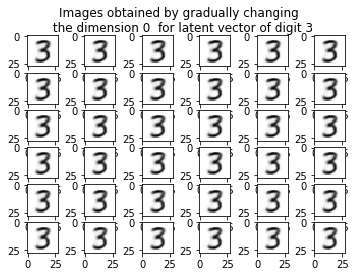

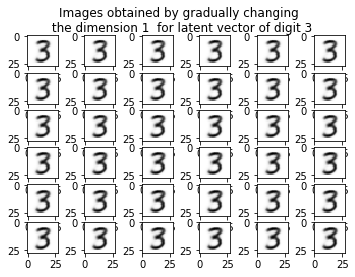

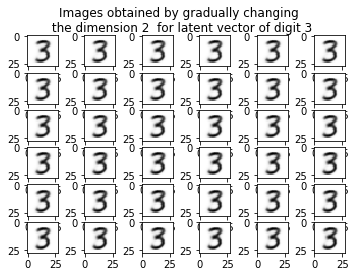

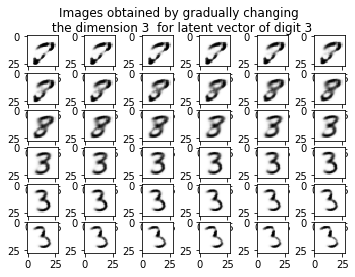

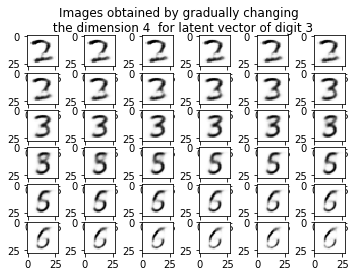

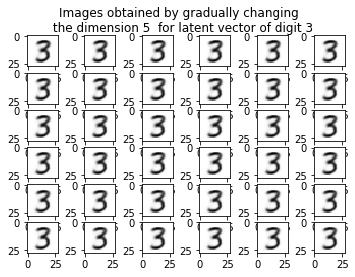

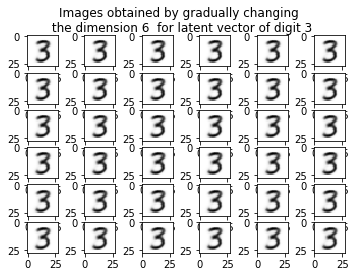

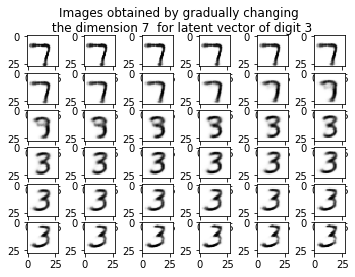

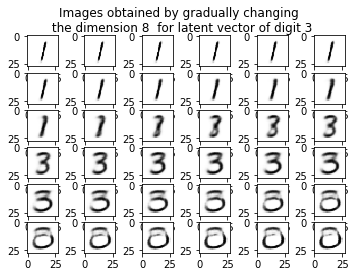

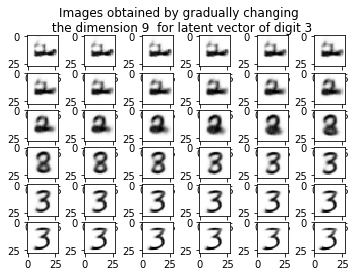

In [17]:
d = 3

num_images_plotted = d * Z_DIM * num_trace_steps
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
for dim in range(10):
    fig = plt.figure()
    fig.suptitle(title_string.format(dim,d))
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6,6,i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)
    num_images_plotted += num_trace_steps
    plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

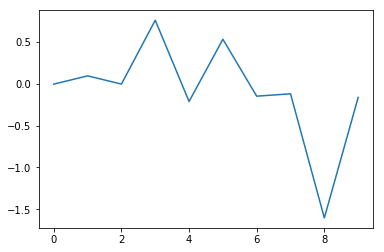

In [19]:
plt.plot(mu_mean[0])

In [20]:
z.shape
d

3

In [21]:
from collections import defaultdict
sensitive_dimensions = defaultdict(list)
for d in range(10):
    num_digits_completed = d * num_trace_steps * Z_DIM
    for dim in range(Z_DIM):
        distances = []
        for step_num in range(num_trace_steps):
            distances.append(np.linalg.norm(reconstructed_images_mean[d] - reconstructed_images[num_digits_completed + num_trace_steps * dim : num_digits_completed + (num_trace_steps * dim) + step_num] ))
        max_distance = max(distances)
        #print("Dimension {} Senssitivity {}".format(dim,max_distance))

        if max_distance > 10:
            sensitive_dimensions[d].append(dim)
        

In [22]:
for k,i in sensitive_dimensions.items():
    print(k,i)

0 [3, 4, 7, 8, 9]
1 [3, 4, 7, 8, 9]
2 [3, 4, 7, 8, 9]
3 [3, 4, 7, 8, 9]
4 [3, 4, 7, 8, 9]
5 [3, 4, 7, 8, 9]
6 [3, 4, 7, 8, 9]
7 [3, 4, 7, 8, 9]
8 [3, 4, 7, 8, 9]
9 [3, 4, 7, 8, 9]


In [30]:
for d in range(10):
    indices = np.asarray(sensitive_dimensions[d])
    print(d,np.asarray(mu_mean)[d,indices])

0 [ 0.76076254 -0.21150259 -0.11960177 -1.60469779 -0.16310475]
1 [-0.85187098  0.27899958 -0.39024506  1.68736951  0.61215616]
2 [-0.31093972  1.44523772 -0.71988543 -0.21614072  0.41886294]
3 [-0.32124347  0.77561136 -0.13493117 -0.22187004 -1.64137167]
4 [ 0.19078674 -0.66286678  0.76484983  0.37643463  0.87537385]
5 [ 0.75850697 -0.71040357 -0.69022703 -0.21793607 -0.22807238]
6 [-0.84798371 -0.99053859 -0.60009154 -0.3213101   0.90227732]
7 [ 0.69633625  0.39777007  1.61531765  0.35115794 -0.31290799]
8 [ 0.42246924  0.27279729 -0.01882608 -0.06589761 -0.5518225 ]
9 [ 0.2480715  -0.53572867  0.99661625  0.31042191 -0.02643614]


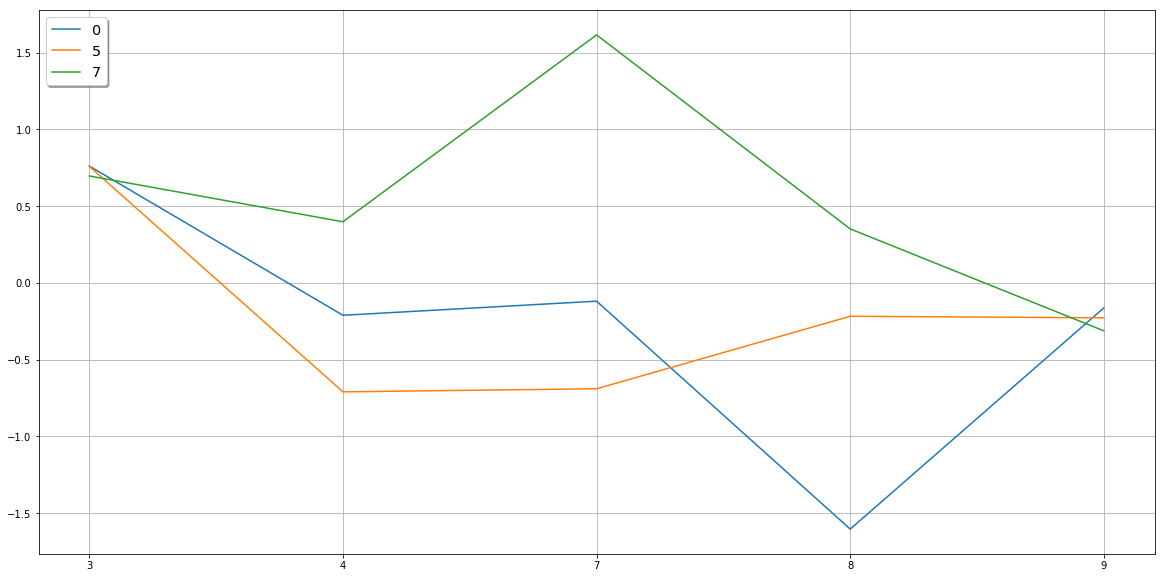

In [43]:

xticks = np.arange(0, indices.shape[0], 1)
plt.figure(figsize=(20,10))
plt.grid(which="both", axis="both")
for d in [0,5,7]:
    plt.plot(np.asarray(mu_mean)[d,indices],label =str(d))
    plt.legend(loc='upper left', shadow=True, fontsize='x-large')
    plt.xticks(xticks,indices)
